In [1]:
library(openxlsx)
library(dplyr)
library(GSVA)
library("survival")
library(survminer)
library(pROC)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [2]:
CELLTYPE_MARKERS_PATH = '/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/publication/cellType_signatures_list.gmt'
SIGNATURES_PATH = '/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/publication/Supplementary Table 3.xlsx'

In [3]:
calScore = function(matrix,gsets, method = 'ssgsea'){
    score = GSVA::gsva(as.matrix(matrix), gset.idx.list = gsets, method=method)
    score = as.data.frame(t(score))
    return(score)
}

getSurvival = function(score, anno, time_name, status_name){
    anno[,'time'] = anno[,time_name]
    anno[,'status'] = anno[,status_name]
    res = c()
    for(g in colnames(score)){
        if(g !='group'){
            anno[,'g'] = as.numeric(score[,g]>median(score[,g],na.rm = T))
            fit <- survdiff(Surv(time, status) ~ g, data = anno)
            res = c(res, 1 - pchisq(fit$chisq, length(fit$n) -1))
        }
    }
    names(res) = colnames(score)[which(colnames(score)!='group')]
    return(res)
}

getROC = function(score,anno){
    res = c()
    for(g in colnames(score)){
    if(g!='group'){
        anno[,'g'] = score[,g]
        res = c(res, auc(roc(anno$Group,anno$g,levels=c("NCR","CR"))))
    }    
    }
    names(res) = colnames(score)[which(colnames(score)!='group')]
    return(res)
}

In [5]:
gsets = testSctpa::getGMT(CELLTYPE_MARKERS_PATH)
sigs = read.xlsx(SIGNATURES_PATH)
progenitor = as.character(sigs[3,4:ncol(sigs)])
progenitor = progenitor[!is.na(progenitor)]
terminal = as.character(sigs[4,4:ncol(sigs)])
terminal = terminal[!is.na(terminal)]

gsets[['Progenitor Exhausted CD8']] = progenitor
gsets[['Terminally Exhausted CD8']] = terminal
gsets[['TLS']] = c('CCL19', 'CCL21', 'CXCL13', 'CCR7', 'SELL', 'LAMP3', 'CXCR4', 'CD86', 'BCL6')
gsets[['signature_pdcd1_spry1_ctla4_cd8a']] = c('CD8A','CTLA4','PDCD1','SPRY1')
gsets[['signature_pdcd1_spry1_cd8a']] = c('CD8A','PDCD1','SPRY1')

## SHC data set
* 12 pre-treatment

In [6]:
load('/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/publication/bulk_data/SHC_ESCC.RData')

In [7]:
SHC_score = calScore(as.matrix(SHC_data),gsets,'ssgsea')

Warning message in .filterFeatures(expr, method):
“1355 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 11 gene sets.
  |======================================================================| 100%



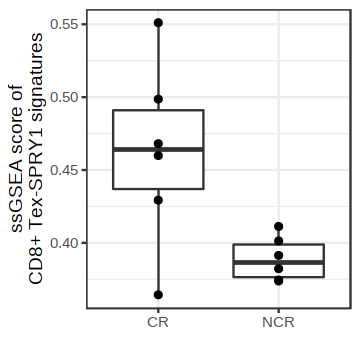

In [9]:
plot_data = SHC_score
plot_data$group = SHC_anno[rownames(plot_data),'Group']
options(repr.plot.width=3, repr.plot.height=3)
ggplot(plot_data,aes(x=group,y=`CD8+Tex_SPRY1`))+geom_boxplot()+geom_point()+theme_bw()+
ylab('ssGSEA score of\nCD8+ Tex-SPRY1 signatures')+xlab('')

In [1370]:
getROC(SHC_score, SHC_anno)

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls > cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



CD8+Tex_SPRY1_markers                       Macro_MMP9 
                       0.8333333                        0.5277778 
                      Bfoc_NEIL1                               Bn 
                       0.7777778                        0.7222222 
                            Bmem                               pB 
                       0.9166667                        0.7222222 
        Progenitor Exhausted CD8         Terminally Exhausted CD8 
                       0.5000000                        0.8888889 
                             TLS signature_pdcd1_spry1_ctla4_cd8a 
                       0.6944444                        0.8611111 
      signature_pdcd1_spry1_cd8a 
                       0.8611111

## TCGA data set

In [11]:
load('/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/publication/bulk_data/TCGA_ESCC.RData')

In [12]:
TCGA_score = calScore(as.matrix(TCGA_data),gsets,'ssgsea')

Warning message in .filterFeatures(expr, method):
“2446 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 11 gene sets.
  |======================================================================| 100%



In [14]:
cor.test(TCGA_score[,'CD8+Tex_SPRY1'],TCGA_score[,'Macro_MMP9'])
cor.test(TCGA_score[,'CD8+Tex_SPRY1'],TCGA_score[,'Bfoc_NEIL1'])
cor.test(TCGA_score[,'Bfoc_NEIL1'],TCGA_score[,'Macro_MMP9'])


	Pearson's product-moment correlation

data:  TCGA_score[, "CD8+Tex_SPRY1"] and TCGA_score[, "Macro_MMP9"]
t = 4.0692, df = 79, p-value = 0.000111
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2177117 0.5817455
sample estimates:
      cor 
0.4162727 



	Pearson's product-moment correlation

data:  TCGA_score[, "CD8+Tex_SPRY1"] and TCGA_score[, "Bfoc_NEIL1"]
t = 7.1334, df = 79, p-value = 4.148e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4720882 0.7427557
sample estimates:
      cor 
0.6259178 



	Pearson's product-moment correlation

data:  TCGA_score[, "Bfoc_NEIL1"] and TCGA_score[, "Macro_MMP9"]
t = 3.493, df = 79, p-value = 0.0007856
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1602032 0.5409090
sample estimates:
      cor 
0.3657583 


`geom_smooth()` using formula 'y ~ x'



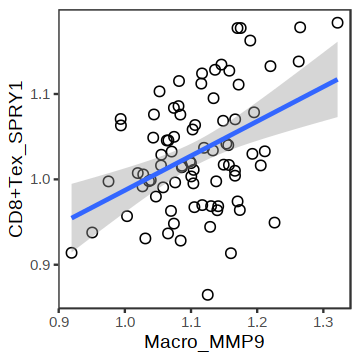

In [16]:
ggplot(TCGA_score,aes(x=`Macro_MMP9`,y=`CD8+Tex_SPRY1`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(
               method = "lm")

`geom_smooth()` using formula 'y ~ x'



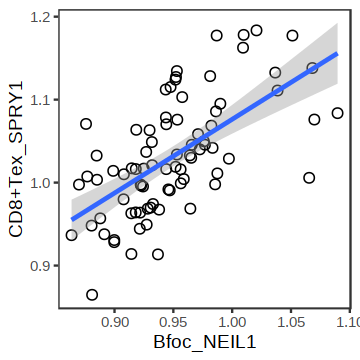

In [17]:
ggplot(TCGA_score,aes(x=`Bfoc_NEIL1`,y=`CD8+Tex_SPRY1`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(
               method = "lm")

`geom_smooth()` using formula 'y ~ x'



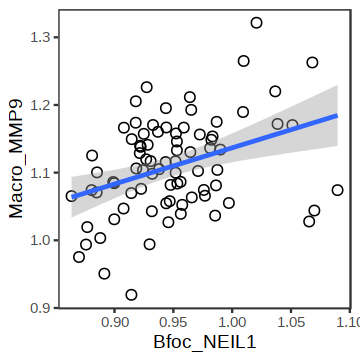

In [18]:
ggplot(TCGA_score,aes(x=`Bfoc_NEIL1`,y=`Macro_MMP9`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(
               method = "lm")

In [19]:
getSurvival(TCGA_score,TCGA_anno,'OS.time','OS')

CD8+Tex_SPRY1                       Macro_MMP9 
                      0.09923346                       0.03207074 
                      Bfoc_NEIL1                               Bn 
                      0.54810443                       0.25607234 
                            Bmem                               pB 
                      0.39855728                       0.36668992 
        Progenitor Exhausted CD8         Terminally Exhausted CD8 
                      0.38790454                       0.13478116 
                             TLS signature_pdcd1_spry1_ctla4_cd8a 
                      0.07239787                       0.03405872 
      signature_pdcd1_spry1_cd8a 
                      0.23591718

## GEO: GSE53625

In [20]:
load('/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/publication/bulk_data/GSE53625_ESCC.RData')

In [21]:
GEO_score = calScore(as.matrix(GEO_data),gsets,'ssgsea')

Estimating ssGSEA scores for 11 gene sets.
  |======================================================================| 100%



In [22]:
cor.test(GEO_score[,'CD8+Tex_SPRY1'],GEO_score[,'Macro_MMP9'])
cor.test(GEO_score[,'CD8+Tex_SPRY1'],GEO_score[,'Bfoc_NEIL1'])
cor.test(GEO_score[,'Bfoc_NEIL1'],GEO_score[,'Macro_MMP9'])


	Pearson's product-moment correlation

data:  GEO_score[, "CD8+Tex_SPRY1"] and GEO_score[, "Macro_MMP9"]
t = 12.063, df = 177, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5824094 0.7449794
sample estimates:
      cor 
0.6717026 



	Pearson's product-moment correlation

data:  GEO_score[, "CD8+Tex_SPRY1"] and GEO_score[, "Bfoc_NEIL1"]
t = 14.369, df = 177, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6578937 0.7948864
sample estimates:
      cor 
0.7337618 



	Pearson's product-moment correlation

data:  GEO_score[, "Bfoc_NEIL1"] and GEO_score[, "Macro_MMP9"]
t = 9.9415, df = 177, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4954126 0.6851113
sample estimates:
      cor 
0.5985894 


`geom_smooth()` using formula 'y ~ x'



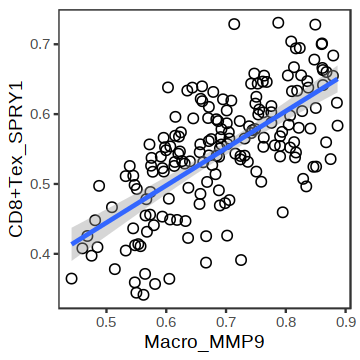

In [23]:
ggplot(GEO_score,aes(x=`Macro_MMP9`,y=`CD8+Tex_SPRY1`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(method = "lm")

`geom_smooth()` using formula 'y ~ x'



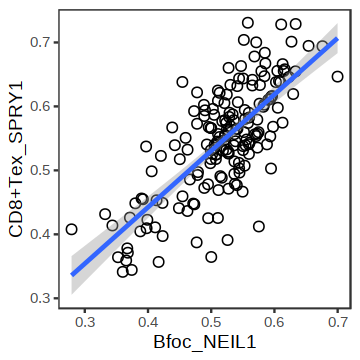

In [24]:
ggplot(GEO_score,aes(x=`Bfoc_NEIL1`,y=`CD8+Tex_SPRY1`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(method = "lm")

`geom_smooth()` using formula 'y ~ x'



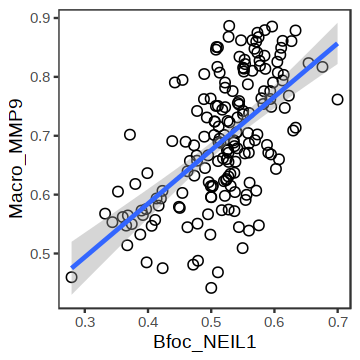

In [25]:
ggplot(GEO_score,aes(x=`Bfoc_NEIL1`,y=`Macro_MMP9`))+
geom_point(shape=1,size=2.3)+
theme_bw()+theme(
    panel.grid = element_blank(),
    panel.background = element_blank()
)+ geom_smooth(method = "lm")

In [26]:
getSurvival(GEO_score[rownames(GEO_anno),],GEO_anno,'RFS_months','RFS_state')

CD8+Tex_SPRY1                       Macro_MMP9 
                       0.9141032                        0.8264280 
                      Bfoc_NEIL1                               Bn 
                       0.1136118                        0.8349634 
                            Bmem                               pB 
                       0.9115861                        0.4846279 
        Progenitor Exhausted CD8         Terminally Exhausted CD8 
                       0.4077637                        0.1910054 
                             TLS signature_pdcd1_spry1_ctla4_cd8a 
                       0.3652986                        0.2443445 
      signature_pdcd1_spry1_cd8a 
                       0.1027711

In [30]:
write.xlsx(list(SHC_score = SHC_score, TCGA_score = TCGA_score, GEO_score = GEO_score), 
           file = '/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/publication/final/Signatures_all_SCT_rankFC_20221213.xlsx',
          rowNames=T)